#### Training GAT networks
* consisting of 3 GAT layers
* training networks using batch size
* features including floor area and the angels between strets

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import datetime
import geopandas as gpd
import momepy
import mlflow
import math
import networkx as nx
import numpy as np
from pathlib import Path
from shapely import LineString
import torch
# from torch_geometric.transforms import NormalizeScale
from torch_geometric.utils.convert import from_networkx
from utils.config import SIGNATURE


params = {
    "adam_learning_rate": 0.01,
    "adam_betas": (0.9, 0.999),
    "adam_eps": 1e-08,
    "adam_weight_decay": 0.001,
    "sgd_learning_rate": 0.0001,
    "sgd_momentum": 0.8,
    "sgd_weight_decay": 0.0001, 
    "train_ratio": 0.8,
    "num_hidden_channels" : 12,
    "GNN_dropout_rate": 0.1,
    "head_num": 16,
    "optimizer":0, #0:Adam, 1:SGD
    "scheduler":0
    # "scheduler_gamma": [0.8],
    # "pos_weight": [1.3],   
    # "model_embedding_size": [64],
    # "model_attention_heads": [3],
    # "model_layers": [4],
    # "model_dropout_rate": [0.2],
    # "model_top_k_ratio": [0.5],
    # "model_top_k_every_n": [1],
    # "model_dense_neurons": [256]
}

In [2]:
# Specify tracking server
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Predict bike traffic_GAT_fixed_floor_area")

<Experiment: artifact_location='./mlruns/9', creation_time=1679385969289, experiment_id='9', last_update_time=1679385969289, lifecycle_stage='active', name='Predict bike traffic_GAT_fixed_floor_area', tags={}>

In [64]:
prefix_name = "testF4mean"
place_name = "Dresden"
file_name = place_name + "_" + prefix_name

len_normalize = 100

data_path = Path().resolve()/"data"/"processed"/f"{file_name}.gpkg"
traffic = gpd.read_file(data_path,driver='GPKG', layer='traffic')
print(f"loading data from {data_path}")


traffic = traffic.to_crs(4839)


loaded_graph = momepy.gdf_to_nx(traffic, approach="primal")
nodes = max(nx.connected_components(loaded_graph), key=len)
connected_graph = nx.subgraph(loaded_graph, nodes)
connected_graph = nx.Graph(connected_graph)
)


num_idx_graph = nx.convert_node_labels_to_integers(connected_graph, label_attribute="coordinate")
node_loc = {i: num_idx_graph.nodes[i]["coordinate"] for i in range(num_idx_graph.number_of_nodes())}

lineGraph = nx.line_graph(num_idx_graph)

attr_list = [
    "mm_len", "occurrence", "bikeability","floor_area",
    "department_store","supermarket","kiosk","variety_store","foodstore",
    "bakery","ice_cream","bookstore","ticket","copyshop","fashion","DIY",
    "houseware","furniture","electronics","sportstore","florist","laundry",
    "petstore","toystore","cafe","restaurant","pub","theatre","cinema",
    "market","place_of_worship","bank","pharmacy","chemist","post_office",
    "townhall","library","kindergarten","school", "college","park","stadium",
    "sportplace","university"
]    
attr_list_no_occurrence = [
    "mm_len", "bikeability","floor_area",
    "department_store","supermarket","kiosk","variety_store","foodstore",
    "bakery","ice_cream","bookstore","ticket","copyshop","fashion","DIY",
    "houseware","furniture","electronics","sportstore","florist","laundry",
    "petstore","toystore","cafe","restaurant","pub","theatre","cinema",
    "market","place_of_worship","bank","pharmacy","chemist","post_office",
    "townhall","library","kindergarten","school", "college","park","stadium",
    "sportplace","university"
]   

for node in lineGraph.copy():
    attr_dict = {attr_name: num_idx_graph.edges[node][attr_name] for attr_name in attr_list}
    lineGraph.add_node(node, **attr_dict)

# Set the edge attribute to the angle between edges
for e in lineGraph.copy().edges:
    u, v = e
    pos_u = np.array(num_idx_graph.nodes[u[0]]['coordinate'])-\
        np.array(num_idx_graph.nodes[u[1]]['coordinate'])
    pos_v = np.array(num_idx_graph.nodes[v[0]]['coordinate'])-\
        np.array(num_idx_graph.nodes[v[1]]['coordinate'])
    dot_product = np.dot(pos_u, pos_v)
    norm_product = np.linalg.norm(pos_u) * np.linalg.norm(pos_v)
    if norm_product == 0:
        angle = 0 if dot_product > 0 else math.pi
    else:
        angle = np.arccos(dot_product / norm_product)
    lineGraph.edges[e]['angle'] = angle/math.pi


data = from_networkx(lineGraph, group_node_attrs=attr_list_no_occurrence, 
                     group_edge_attrs=['angle'])
data.x[:,0] = data.x[:,0]/len_normalize
data.y = data.occurrence.unsqueeze(1)
del data.occurrence
print(data)

loading data from E:\MyDoc\MPI_Thinkvitality\Big Data23\code\bike-flow-prediction\data\processed\Dresden_testF4mean.gpkg
Data(edge_index=[2, 55050], x=[12912, 43], edge_attr=[55050, 1], y=[12912, 1])


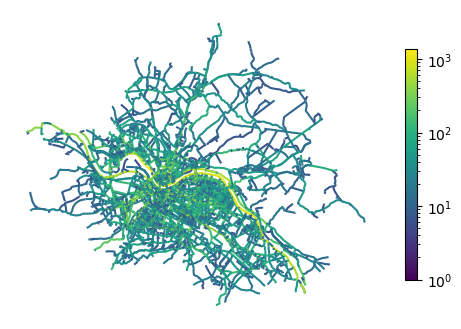

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

_, gdf_edges = momepy.nx_to_gdf(connected_graph)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
gdf_edges.plot(
        column="occurrence",
        ax=ax,
        legend=True, 
        legend_kwds={"shrink": 0.5},
        norm=colors.LogNorm(vmin=1, 
        vmax=gdf_edges["occurrence"].max())
)
ax.set_axis_off()

fig_path = Path().resolve()/"data"/"image"/f"{file_name}.svg"
plt.savefig(fig_path, format="svg")


Split the data to trains and test sets

In [68]:
now = datetime.datetime.now()
time_tag = now.strftime("%m%d_%H%M")

data.train_mask = torch.rand(data.num_nodes) < params["train_ratio"]
data.test_mask = ~data.train_mask
train_mask_path = Path().resolve()/"data"/"mask"/f"{file_name}_{time_tag}.npy"
np.save(train_mask_path, data.train_mask)

In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [70]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv

# hidden_channels=16

# Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()

        # GNN layers
        self.conv1 = GATConv(data.num_features, hidden_channels,
                             heads=params["head_num"])
        self.conv2 = GATConv(hidden_channels*params["head_num"], hidden_channels,
                             heads=params["head_num"])                                                                
        self.conv3 = GATConv(hidden_channels*params["head_num"], hidden_channels,
                             heads=1, concat=False)
        
        # linear layers
        self.linear1 = Linear(hidden_channels, 24)
        self.linear2 = Linear(24, 24)                
        self.linear3 = Linear(24, 1)              
     
     
    def forward(self, x, edge_index, edge_attr):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=params["GNN_dropout_rate"], training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=params["GNN_dropout_rate"], training=self.training)

        # Third Message Passing Layer
        x = self.conv3(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=params["GNN_dropout_rate"], training=self.training)

        # linear layer 
        x = self.linear1(x)
        x = F.elu(x)
        x = self.linear2(x)
        x = F.elu(x)        
        x = self.linear3(x)     
        return x

model = GAT(params["num_hidden_channels"])
print(model)
print(f"Number of parameters: {count_parameters(model)}")


GAT(
  (conv1): GATConv(43, 12, heads=16)
  (conv2): GATConv(192, 12, heads=16)
  (conv3): GATConv(192, 12, heads=1)
  (linear1): Linear(in_features=12, out_features=24, bias=True)
  (linear2): Linear(in_features=24, out_features=24, bias=True)
  (linear3): Linear(in_features=24, out_features=1, bias=True)
)
Number of parameters: 49549


In [71]:
from torch_geometric.loader import ClusterData, ClusterLoader

# torch.manual_seed(12345)
cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs. 128
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme. 32

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')


Step 1:
Number of nodes in the current batch: 3220
Data(x=[3220, 43], edge_attr=[12996, 1], y=[3220, 1], train_mask=[3220], test_mask=[3220], edge_index=[2, 12996])

Step 2:
Number of nodes in the current batch: 3218
Data(x=[3218, 43], edge_attr=[13048, 1], y=[3218, 1], train_mask=[3218], test_mask=[3218], edge_index=[2, 13048])

Step 3:
Number of nodes in the current batch: 3242
Data(x=[3242, 43], edge_attr=[13136, 1], y=[3242, 1], train_mask=[3242], test_mask=[3242], edge_index=[2, 13136])

Step 4:
Number of nodes in the current batch: 3232
Data(x=[3232, 43], edge_attr=[12928, 1], y=[3232, 1], train_mask=[3232], test_mask=[3232], edge_index=[2, 12928])

Iterated over 12912 of 12912 nodes!


Computing METIS partitioning...
Done!


Epoch: 000, Train Loss: 162.7, Test Loss: 162.1
Epoch: 200, Train Loss: 113.1, Test Loss: 124.0
Epoch: 400, Train Loss: 107.5, Test Loss: 125.3
Epoch: 600, Train Loss: 94.2, Test Loss: 120.2
Epoch: 800, Train Loss: 91.4, Test Loss: 124.4
Epoch: 1000, Train Loss: 85.3, Test Loss: 124.3
Epoch: 1200, Train Loss: 84.1, Test Loss: 122.3
Epoch: 1400, Train Loss: 84.9, Test Loss: 123.0
Epoch: 1600, Train Loss: 80.0, Test Loss: 118.7
Epoch: 1800, Train Loss: 83.3, Test Loss: 122.3
Epoch: 2000, Train Loss: 75.5, Test Loss: 121.5
Epoch: 2200, Train Loss: 74.1, Test Loss: 122.5
Epoch: 2400, Train Loss: 73.8, Test Loss: 122.8
Epoch: 2600, Train Loss: 71.0, Test Loss: 122.9
Epoch: 2800, Train Loss: 69.9, Test Loss: 121.7
Epoch: 3000, Train Loss: 72.6, Test Loss: 120.9
Early stopping due to no improvement.


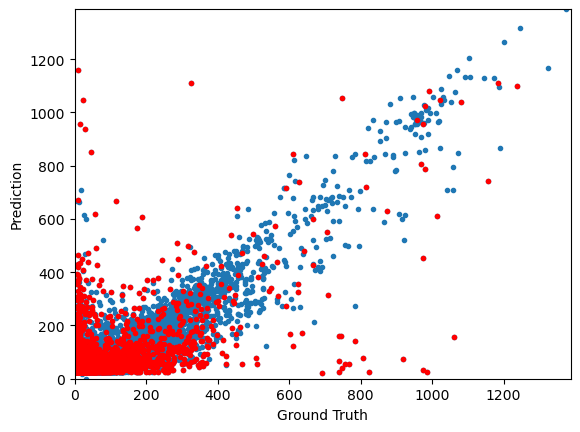

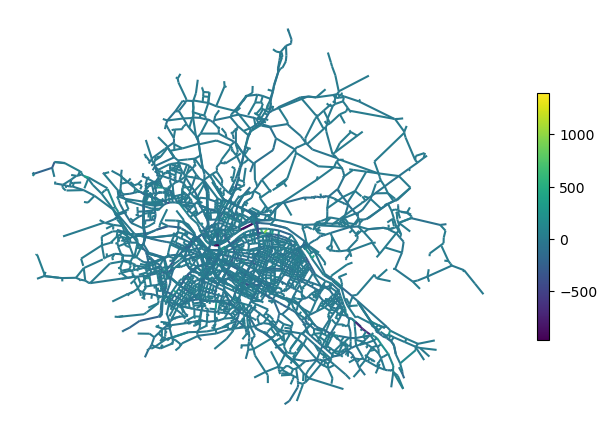

In [72]:
# Initialize model

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
data = data.to(device)

# Initialize Optimizer

if params["optimizer"]==0:
      optimizer = torch.optim.Adam(model.parameters(), 
                             lr=params["adam_learning_rate"],
                             betas=params["adam_betas"],
                             eps=params["adam_eps"],
                             weight_decay=params["adam_weight_decay"]
                              )
else:
      optimizer = torch.optim.SGD(model.parameters(), 
                        lr=params["sgd_learning_rate"],
                        momentum=params["sgd_momentum"],
                        weight_decay=params["sgd_weight_decay"],
                        nesterov=True
                        )
      
if params["scheduler"]==1:
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                            T_max=500,
                                                            eta_min=0.000001
                                                            )


# Define loss function 
criterion = MSELoss()
# criterion = L1Loss()

def train():
      model.train()
      running_loss = 0.0
      step = 0

      for sub_data in train_loader:  # Iterate over each mini-batch.
            optimizer.zero_grad() 
            # Use all data as input, because all nodes have node features
            # out = model(data.x, data.edge_index)
            out = model(sub_data.x, sub_data.edge_index, sub_data.edge_attr)  # Perform a single forward pass.

            # Only use nodes with labels available for loss calculation --> mask
            # loss = criterion(out[data.train_mask], data.y[data.train_mask]) 
            loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
            loss.backward() 
            optimizer.step()
            running_loss += loss.item()
            step += 1  

      return running_loss/step

def test():
      model.eval()
      out = model(data.x, data.edge_index, data.edge_attr)
      loss = criterion(out[data.test_mask], data.y[data.test_mask])
      return loss


# animation setting
do_animation = 0
animation_count = 0
max_groud_value = max(data.y.detach().numpy())
mask = data.train_mask.numpy()

max_epoch = 5001
max_early_stopping_counter = 500
# best_train_loss = 100000
best_test_loss = 100000
nocheck_until = 2000
early_stopping_counter = 0

# train_losses = []
# test_losses = []

with mlflow.start_run() as run:
      mlflow.log_param("input_file", file_name)
      mlflow.log_param("num_params", count_parameters(model))
      mlflow.log_artifact(fig_path)
      mlflow.log_artifact(train_mask_path)

      for key in params.keys():
            mlflow.log_param(key, params[key])

      for epoch in range(max_epoch):
            if early_stopping_counter <= max_early_stopping_counter:
                  #train
                  train_loss = np.sqrt(train())
                  mlflow.log_metric(key="Train loss", value=float(train_loss), step=epoch)

                  #test
                  test_loss = torch.sqrt(test())
                  mlflow.log_metric(key="Test loss", value=float(test_loss), step=epoch)

                  if epoch > nocheck_until: #do not check early_stopping after some epochs 
                                         
                        if float(test_loss) < best_test_loss:
                              best_test_loss = test_loss
                              mlflow.pytorch.log_model(model, "model", signature=SIGNATURE) 
                              early_stopping_counter = 0
                        else:
                              early_stopping_counter += 1                                     
                  # scheduler.step()
            else:
                  print("Early stopping due to no improvement.")
                  break

            if epoch % 200 == 0:
                  print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.1f}, Test Loss: {test_loss:.1f}")

            if epoch % 10 == 0 and do_animation == 1:  
                  prediction = model(data.x, data.edge_index)
                  truth = data.y.detach().numpy()                
                  prediction = prediction.detach().numpy()
                  pair_predict = np.concatenate((truth, prediction), axis=1)
                  
                  animation_path = Path().resolve()/"data"/"anima"/\
                        f"{file_name}_{time_tag}_{animation_count:03d}.png"

                  
                  scatter1 = plt.plot(pair_predict[mask.transpose().ravel(),0],
                        pair_predict[mask.transpose().ravel(),1],
                        'o', color='royalblue', markersize=2, label ='train data')
                  scateer2 = plt.plot(pair_predict[~mask.transpose().ravel(),0],
                        pair_predict[~mask.transpose().ravel(),1],
                        'o', color='indianred', markersize=2, label ='test data')
                  
                  plt.text(-300, -300, f'epoch: {epoch:04d}', fontsize='medium')
                  plt.xlabel("Ground Truth")
                  plt.ylabel("Prediction")
                  plt.xlim([0, max_groud_value])
                  plt.ylim([0, max_groud_value])
                  plt.legend(loc='upper left')                   
                  plt.savefig(animation_path, format="png", dpi=200)     
                  plt.close()

                  animation_count += 1

      # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE) 
      
      # plot
      
      result_path = Path().resolve()/"data"/"image"/f"{file_name}_{time_tag}.svg"
      result_Emap_path = Path().resolve()/"data"/"image"/f"{file_name}_{time_tag}_Emap.svg"

      prediction = model(data.x, data.edge_index, data.edge_attr)
      truth = data.y.detach().numpy()
      prediction = prediction.detach().numpy()
      error = prediction - truth
      pair_predict = np.concatenate((truth, prediction), axis=1)

      plt.plot(pair_predict[:,0], pair_predict[:,1], "o", markersize=3)
      plt.plot(pair_predict[data.test_mask,0], pair_predict[data.test_mask,1], "or", markersize=3)
      plt.xlabel("Ground Truth")
      plt.ylabel("Prediction")
      plt.xlim([0, max(pair_predict[:,0])])
      plt.ylim([0, max(pair_predict[:,0])])
      plt.savefig(result_path, format="svg")     
      plt.show()      

      lines = [LineString([node_loc[node[0]], node_loc[node[1]]]) for node in lineGraph.nodes]
      readout_gdf = gpd.GeoDataFrame({"error": error.ravel(),
                                    "geometry":lines}, crs="EPSG:4839")

      fig, ax = plt.subplots(1, 1, figsize=(8,8))
      readout_gdf.plot(
      column="error",
      ax=ax,
      legend=True, 
      legend_kwds={"shrink": 0.4},
      # norm=colors.LogNorm(vmin=1, vmax=1200)
                  )
      ax.set_axis_off()
      plt.savefig(result_Emap_path, format="svg")     
      plt.show()

      mlflow.log_artifact(result_path)
      mlflow.log_artifact(result_Emap_path)

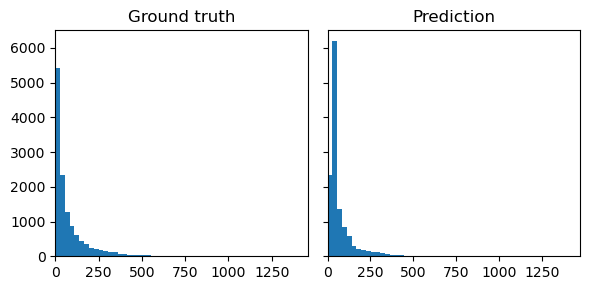

In [74]:
n_bins = 50
bin_range1 = (0, np.max(truth))
bin_range2 = (0, np.max(prediction))
# bin_range2 = (0, 200)


fig, axes = plt.subplots(1,2, figsize=(6,3), sharey=True)
axes[0].hist(truth, bins=n_bins, range=bin_range1)
axes[0].set_title('Ground truth')
axes[0].set_xlim(left=0)

axes[1].hist(prediction, bins=n_bins, range=bin_range2)
axes[1].set_title('Prediction')
axes[1].set_xlim(left=0)

# plt.xlim(bin_range)
plt.tight_layout()
plt.show()

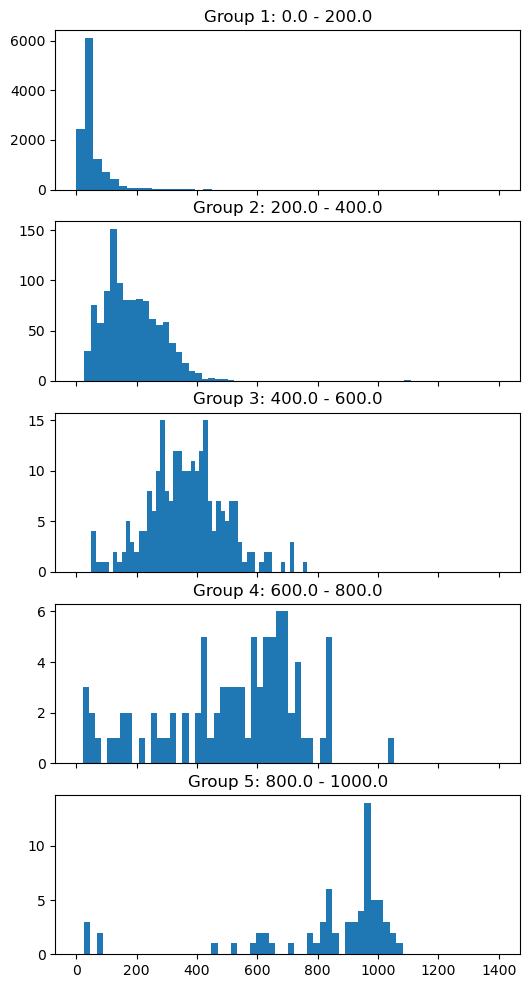

In [75]:
# Define number of groups
num_groups = 5
max_value = 1000

pair_predict = np.concatenate((truth, prediction), axis=1)

# Split data into groups based on values of the first element
grouped_data = [pair_predict[(pair_predict[:, 0] >= i * max_value / num_groups) & 
                             (pair_predict[:, 0] < (i + 1) * max_value / num_groups)] for i in range(num_groups)]

# Plot histograms for each group
fig, axs = plt.subplots(num_groups, 1, figsize=(6, 12), sharex=True)
for i in range(num_groups):
    axs[i].hist(grouped_data[i][:, 1], bins=50)
    axs[i].set_title(f'Group {i+1}: {i*1000/num_groups} - {(i+1)*1000/num_groups}')

plt.show()


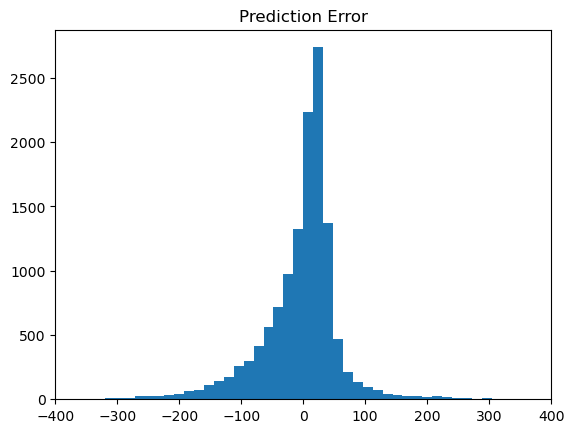

In [77]:
n_bins = 50
bin_range = (-400, 400)
plt.hist(error, bins=n_bins, range=bin_range)
plt.title('Prediction Error')
plt.xlim(bin_range)
plt.show()